# SPACETOP Biopac: Pain Condition

### Load libraries 

In [93]:
import neurokit2 as nk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from pathlib import Path
from os.path import join
import itertools
from statistics import mean

plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images
plt.rcParams['font.size']= 14

## Get data 
### Load data path 

In [ ]:
pwd = os.getcwd()
main_dir = Path(pwd).parents[1]

### Load subject data

In [ ]:
# sub-0051
# ses-03
sub_num = 51
ses_num = 3
run_num = 2
sub = f"sub-{sub_num:04d}"
ses = f"ses-{ses_num:02d}"
run = f"run-{run_num-1:02d}"
physio_fname = join(main_dir, 'data', sub, ses, 'physio', f"SOCIAL_spacetop_{sub}_{ses}_task-social_ANISO.acq")
beh_fname = glob.glob(join(main_dir, 'data', sub, ses, 'beh', f"{sub}_{ses}_task-social_{run}-*_beh.csv"))[0]

### Check data & define dataframes for physio and behavioral data

In [ ]:
print("load physio data...")
physio_df, spacetop_samplingrate = nk.read_acqknowledge(physio_fname)
print("check physio data columns: ",physio_df.columns)

beh_df = pd.read_csv(beh_fname)

### Plot trigger channels

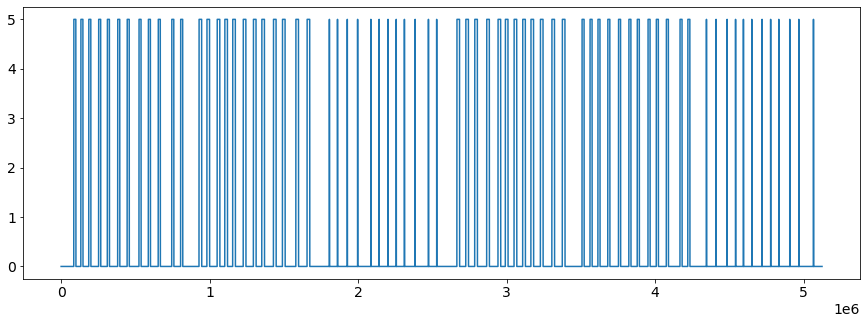

In [41]:
plt.plot(physio_df["administer"])

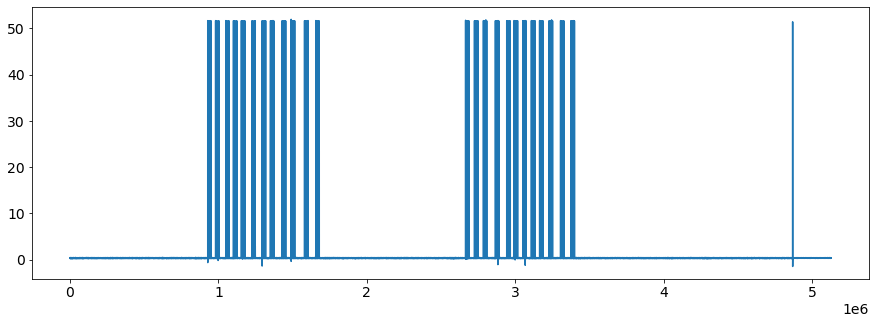

In [42]:
plt.plot(physio_df['TSA2 TTL - CBLCFMA - Current Feedback M'])

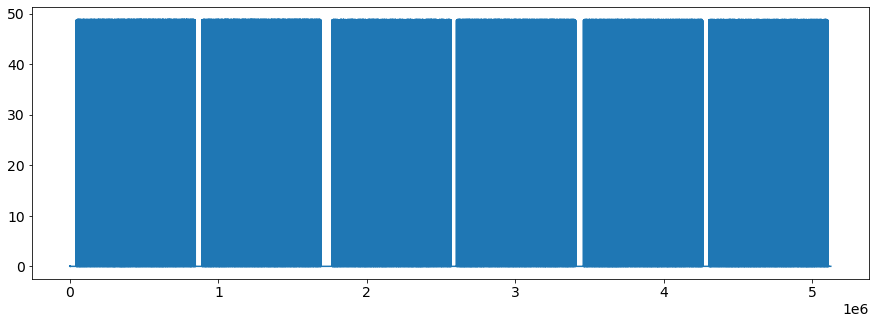

In [43]:
plt.plot(physio_df['fMRI Trigger - CBLCFMA - Current Feedba'])

(@Heejung, this comment was integrated from your script - I think we are good w/o downsampling?)
(TODO:
- change columns so they match figure
- downsample data)

## Organize data (preprocess biopac digital channels)

### 1. Extract run based on trigger column 

In [44]:
mid_val = (np.max(physio_df['trigger']) - np.min(physio_df['trigger']))/2
physio_df.loc[physio_df['trigger'] > mid_val, 'fmri_trigger'] = 5
physio_df.loc[physio_df['trigger'] <= mid_val, 'fmri_trigger'] = 0

start_df = physio_df[physio_df['fmri_trigger'] > physio_df['fmri_trigger'].shift(1)].index
stop_df = physio_df[physio_df['fmri_trigger'] < physio_df['fmri_trigger'].shift(1)].index
print(f"* indices of each run's start point 'start_df': \n\t{start_df}")
print(f"* indices of each run's end point: 'stop_df': \n\t{stop_df}") 

# Organize data: transition
df_transition = pd.DataFrame({
                        'start_df': start_df, 
                        'stop_df': stop_df
                        })
run_subset = physio_df[df_transition.start_df[run_num-1]: df_transition.stop_df[run_num-1]]
run_df = run_subset.reset_index()
print("\n* extract dataframe based on run number")
run_df.head()

* indices of each run's start point 'start_df': 
	Int64Index([43850, 890568, 1765932, 2603584, 3458812, 4302610], dtype='int64')
* indices of each run's end point: 'stop_df': 
	Int64Index([841528, 1688195, 2563573, 3401638, 4256488, 5100278], dtype='int64')

* extract dataframe based on run number


,index,Skin Conductance (EDA) - EDA100C-MRI,Pulse (PPG) - PPG100C,fMRI Trigger - CBLCFMA - Current Feedba,TSA2 TTL - CBLCFMA - Current Feedback M,trigger,fixation,cue,expect,administer,actual,C15,C16,fmri_trigger
0,890568,9.777831,-0.016174,0.009155,0.308228,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,890569,9.774779,-0.016174,0.009155,0.317383,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,890570,9.779357,-0.017090,0.009155,0.329590,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,890571,9.777831,-0.017090,0.003052,0.372314,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,890572,9.776305,-0.016479,0.012207,0.329590,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


### 2. Baseline correction
We will usee three baseline correction methods
1) subtract mean baseline, using the 6 TRs
2) using the fixation period from tthe entire run 
3) using the fixation period from corresponding trial

In [45]:
# ['Skin Conductance (EDA) - EDA100C-MRI'].loc[0:5520].mean()
fix_bool = run_df['fixation'].astype(bool).sum()
print(f"confirming the number of fixation non-szero timepoints: {fix_bool}")
print(f"this amounts to {fix_bool/2000} seconds")

confirming the number of fixation non-szero timepoints: 357248
this amounts to 178.624 seconds


baseline using the 6 TR: 9.62573771505028
baseline using fixation from entire run: 8.379528779141685


<AxesSubplot:>

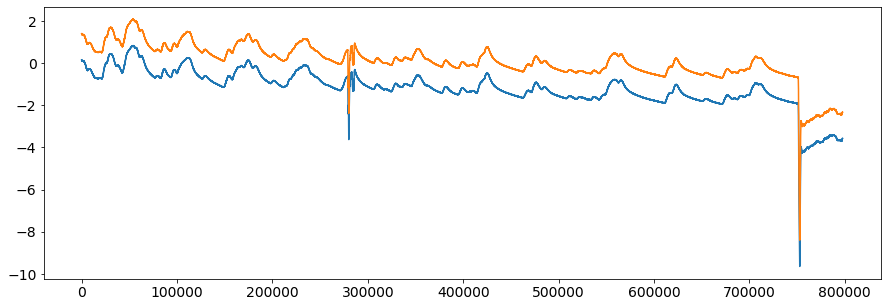

In [46]:

# baseline correction
baseline_method01 = run_df['Skin Conductance (EDA) - EDA100C-MRI'].loc[0:5520].mean()
run_df['EDA_corrected_01tr'] = run_df['Skin Conductance (EDA) - EDA100C-MRI'] - baseline_method01

mask = run_df['fixation'].astype(bool)
baseline_method02 = run_df['Skin Conductance (EDA) - EDA100C-MRI'].loc[mask].mean()
run_df['EDA_corrected_02fixation'] = run_df['Skin Conductance (EDA) - EDA100C-MRI'] - baseline_method02

# TODO: per trial, grab the baseline fixation average signal

print(f"baseline using the 6 TR: {baseline_method01}")
print(f"baseline using fixation from entire run: {baseline_method02}")
run_df['EDA_corrected_01tr'].plot()
run_df['EDA_corrected_02fixation'].plot()
# TODO: add legend, which color is which?

### 3. Create events
3.1 Extract events based on cue

In [47]:
mid_val = (np.max(run_df['cue']) - np.min(run_df['cue']))/2
run_df.loc[run_df['cue'] > mid_val, 'cue'] = 5
run_df.loc[run_df['cue'] <= mid_val, 'cue'] = 0

start_cue = run_df[run_df['cue'] > run_df[ 'cue'].shift(1)]
stop_cue = run_df[run_df['cue'] < run_df[ 'cue'].shift(1)]
print(f"* indices of cue events' start point 'start_cue': \n\t{start_cue.index}")
print(f"* indices of cue events' end point: 'stop_cue': \n\t{stop_cue.index}")

cue_freq = len(start_cue)
print(f"* total number of trials: {cue_freq}")

* indices of cue events' start point 'start_cue': 
	Int64Index([ 15790,  75179, 133368, 190990, 251795, 303964, 374960, 446785,
            518578, 583368, 657363, 739160],
           dtype='int64')
* indices of cue events' end point: 'stop_cue': 
	Int64Index([ 17746,  77146, 135346, 192946, 253746, 305945, 376945, 448745,
            520545, 585345, 659345, 741145],
           dtype='int64')
* total number of trials: 12


3.2 Extract events based on expect_rating 

In [48]:
mid_val = (np.max(run_df['expect']) - np.min(run_df['expect']))/2
run_df.loc[run_df['expect'] > mid_val, 'expect_rating'] = 5
run_df.loc[run_df['expect'] <= mid_val, 'expect_rating'] = 0

start_expectrating = run_df[run_df['expect_rating'] > run_df[ 'expect_rating'].shift(1)]
stop_expectrating = run_df[run_df['expect_rating'] < run_df[ 'expect_rating'].shift(1)]
print(f"* indices of expect-rating events' start point 'start_expectrating': \n\t{start_expectrating.index}")
print(f"* indices of expect-rating events' end point: 'stop_expectrating': \n\t{stop_expectrating.index}")

expectrating_freq = len(start_expectrating)
print(f"* total number of trials: {expectrating_freq}")

* indices of expect-rating events' start point 'start_expectrating': 
	Int64Index([ 20225,  79992, 137793, 197991, 255192, 310991, 379392, 451192,
            525592, 588192, 662192, 743194],
           dtype='int64')
* indices of expect-rating events' end point: 'stop_expectrating': 
	Int64Index([ 23259,  82859, 141436, 200559, 257359, 316601, 382359, 453726,
            529326, 594538, 665198, 748796],
           dtype='int64')
* total number of trials: 12


3.3 Extract events based on stimulus intensity

In [49]:
mid_val = (np.max(run_df['administer']) - np.min(run_df['administer']))/2
run_df.loc[run_df['administer'] > mid_val, 'stimuli'] = 5
run_df.loc[run_df['administer'] <= mid_val, 'stimuli'] = 0

start_stim = run_df[run_df['stimuli'] > run_df[ 'stimuli'].shift(1)]
stop_stim = run_df[run_df['stimuli'] < run_df[ 'stimuli'].shift(1)]
print(f"* indices of stimulus events' start point 'start_stim': \n\t{start_stim.index}")
print(f"* indices of stimulus events' end point: 'stop_stim': \n\t{stop_stim.index}")

run_df[run_df[ 'stimuli'].diff() != 0].index
stim_freq = len(start_stim)
print(f"* total number of trials: {stim_freq}")

* indices of stimulus events' start point 'start_stim': 
	Int64Index([ 37732,  90817, 159839, 211206, 264438, 335437, 403801, 460417,
            538830, 599433, 689621, 765262],
           dtype='int64')
* indices of stimulus events' end point: 'stop_stim': 
	Int64Index([ 55546, 108746, 177746, 229146, 282347, 353345, 421745, 478345,
            556745, 617345, 707545, 783145],
           dtype='int64')
* total number of trials: 12


3.4 Extract events based on actual_rating

In [50]:
mid_val = (np.max(run_df['actual']) - np.min(run_df['actual']))/2
run_df.loc[run_df['actual'] > mid_val, 'actual_rating'] = 5
run_df.loc[run_df['actual'] <= mid_val, 'actual_rating'] = 0

start_actualrating = run_df[run_df['actual_rating'] > run_df[ 'actual_rating'].shift(1)]
stop_actualrating = run_df[run_df['actual_rating'] < run_df[ 'actual_rating'].shift(1)]
print(f"* indices of actual-rating events' start point 'start_actualrating': \n\t{start_actualrating.index}")
print(f"* indices of actual-rating events' end point: 'stop_actualrating': \n\t{stop_actualrating.index}")

actualrating_freq = len(start_actualrating)
print(f"* total number of trials: {actualrating_freq}")

* indices of actual-rating events' start point 'start_actualrating': 
	Int64Index([ 65992, 114992, 180792, 241592, 294792, 363825, 434394, 490992,
            562992, 620392, 719592, 789593],
           dtype='int64')
* indices of actual-rating events' end point: 'stop_actualrating': 
	Int64Index([ 70359, 117493, 183526, 244774, 298302, 369992, 438092, 495301,
            566161, 628392, 723026, 795193],
           dtype='int64')
* total number of trials: 12


### 4. Extract TTLs: identify ttl events based on TTL column

4.1 Build pandas dataframe

In [51]:
df_onset = pd.DataFrame({
    'expect_start': start_expectrating.index, 
    'actual_end': stop_actualrating.index,
    'stim_start': np.nan,
    'stim_end':np.nan
})

df_stim = pd.DataFrame({
    'stim_start': start_stim.index, 
    'stim_end': stop_stim.index
    })

final_df = pd.DataFrame()

In [52]:
df_stim

,stim_start,stim_end
0,37732,55546
1,90817,108746
2,159839,177746
3,211206,229146
4,264438,282347
5,335437,353345
6,403801,421745
7,460417,478345
8,538830,556745
9,599433,617345


In [53]:
mid_val = (np.max(run_df['TSA2 TTL - CBLCFMA - Current Feedback M']) - np.min(run_df['TSA2 TTL - CBLCFMA - Current Feedback M']))/2
run_df.loc[run_df['TSA2 TTL - CBLCFMA - Current Feedback M'] > mid_val, 'TTL'] = 5
run_df.loc[run_df['TSA2 TTL - CBLCFMA - Current Feedback M'] <= mid_val, 'TTL'] = 0

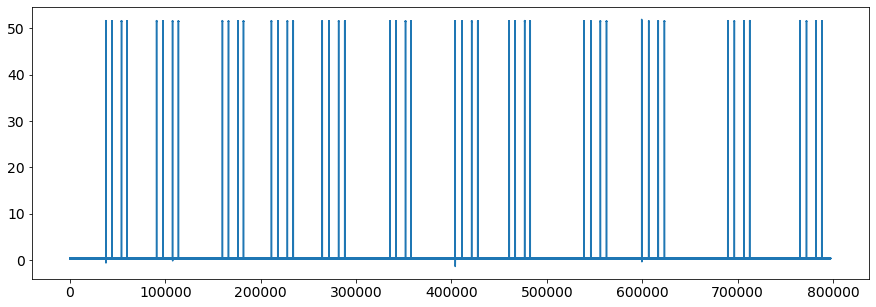

In [54]:
plt.plot(run_df['TSA2 TTL - CBLCFMA - Current Feedback M'])

4.2 Calculate TTL onsets

In [55]:
start_ttl = run_df[run_df['TTL'] > run_df[ 'TTL'].shift(1)]
stop_ttl = run_df[run_df['TTL'] < run_df[ 'TTL'].shift(1)]
ttl_onsets = list(start_ttl.index + (stop_ttl.index-start_ttl.index)/2)
print(f"ttl onsets: {ttl_onsets}, length of ttl onset is : {len(ttl_onsets)}")

ttl onsets: [37752.5, 44102.0, 54105.5, 59809.0, 90885.5, 97633.5, 107636.5, 113742.0, 159898.5, 166227.0, 176227.0, 181974.0, 211280.5, 217981.5, 227979.0, 234087.5, 264494.5, 271691.0, 281693.5, 288168.5, 335485.5, 341834.0, 351837.0, 357631.5, 403879.0, 411157.0, 421157.5, 427555.5, 460481.5, 466712.5, 476710.0, 482495.5, 538904.5, 546083.0, 556086.0, 562489.0, 599508.5, 606725.5, 616726.0, 623192.0, 689701.5, 696519.5, 706520.0, 712618.0, 765324.5, 772133.0, 782136.0, 788239.0], length of ttl onset is : 48


In [56]:
df_onset['expect_start']

0      20225
1      79992
2     137793
3     197991
4     255192
5     310991
6     379392
7     451192
8     525592
9     588192
10    662192
11    743194
Name: expect_start, dtype: int64

In [57]:
for i in range(len(df_stim)):
    idx = pd.IntervalIndex.from_arrays(
        df_onset['expect_start'], df_onset['actual_end'])
    start_val = df_stim.iloc[i][df_stim.columns.get_loc('stim_start')]
    interval_idx = df_onset[idx.contains(start_val)].index[0]
    df_onset.iloc[interval_idx, df_onset.columns.get_loc('stim_start')] = start_val

    end_val = df_stim.iloc[i][df_stim.columns.get_loc('stim_end')]
    interval_idx = df_onset[idx.contains(end_val)].index[0]
    df_onset.iloc[interval_idx, df_onset.columns.get_loc('stim_end')] = end_val
    print(f"this is the {i}-th iteration. stim value is {start_val}, and is in between index {interval_idx}")

# calculate TTL onsets
start_ttl = run_df[run_df['TTL'] > run_df[ 'TTL'].shift(1)]
stop_ttl = run_df[run_df['TTL'] < run_df[ 'TTL'].shift(1)]
ttl_onsets =   list(start_ttl.index + (stop_ttl.index-start_ttl.index)/2)
print(f"ttl onsets: {ttl_onsets}, length of ttl onset is : {len(ttl_onsets)}")

# define empty TTL data frame 
df_ttl = pd.DataFrame(np.nan, 
                    index=np.arange(len(df_onset)),
                    columns= ['ttl_1', 'ttl_2','ttl_3', 'ttl_4'])

# identify which set of TTLs fall between expect and actual 
pad = 1 # seconds. you may increase the value to have a bigger event search interval
df_onset['expect_start_interval'] = df_onset['expect_start']-pad
df_onset['actual_end_interval'] = df_onset['actual_end']+pad
idx = pd.IntervalIndex.from_arrays(
            df_onset['expect_start_interval'], df_onset['actual_end_interval'])

for i in range(len(ttl_onsets)):
    
    val = ttl_onsets[i]
    print(f"{i}-th value: {val}")
    empty_cols = []
    interval_idx = df_onset[idx.contains(val)].index[0]
    print(f"\t\t* interval index: {interval_idx}")
    mask = df_ttl.loc[[interval_idx]].isnull()
    empty_cols = list(itertools.compress(np.array(df_ttl.columns.to_list()), mask.values[0]))
    print(f"\t\t* empty columns: {empty_cols}")
    df_ttl.loc[df_ttl.index[interval_idx], str(empty_cols[0])] = val
    print(f"\t\t* this is the row where the value -- {val} -- falls. on the {interval_idx}-th row")

# merge :: merge df_onset and df_ttl -> final output: final df 
final_df = pd.merge(df_onset, df_ttl, left_index=True, right_index=True)
final_df['ttl_r1'] = final_df['ttl_1'] - final_df['stim_start']
final_df['ttl_r2'] = final_df['ttl_2'] - final_df['stim_start']
final_df['ttl_r3'] = final_df['ttl_3'] - final_df['stim_start']
final_df['ttl_r4'] = final_df['ttl_4'] - final_df['stim_start']

this is the 0-th iteration. stim value is 37732, and is in between index 0
this is the 1-th iteration. stim value is 90817, and is in between index 1
this is the 2-th iteration. stim value is 159839, and is in between index 2
this is the 3-th iteration. stim value is 211206, and is in between index 3
this is the 4-th iteration. stim value is 264438, and is in between index 4
this is the 5-th iteration. stim value is 335437, and is in between index 5
this is the 6-th iteration. stim value is 403801, and is in between index 6
this is the 7-th iteration. stim value is 460417, and is in between index 7
this is the 8-th iteration. stim value is 538830, and is in between index 8
this is the 9-th iteration. stim value is 599433, and is in between index 9
this is the 10-th iteration. stim value is 689621, and is in between index 10
this is the 11-th iteration. stim value is 765262, and is in between index 11
ttl onsets: [37752.5, 44102.0, 54105.5, 59809.0, 90885.5, 97633.5, 107636.5, 113742.0,

In [58]:
final_df

,expect_start,actual_end,stim_start,stim_end,expect_start_interval,actual_end_interval,ttl_1,ttl_2,ttl_3,ttl_4,ttl_r1,ttl_r2,ttl_r3,ttl_r4
0,20225,70359,37732.0,55546.0,20224,70360,37752.5,44102.0,54105.5,59809.0,20.5,6370.0,16373.5,22077.0
1,79992,117493,90817.0,108746.0,79991,117494,90885.5,97633.5,107636.5,113742.0,68.5,6816.5,16819.5,22925.0
2,137793,183526,159839.0,177746.0,137792,183527,159898.5,166227.0,176227.0,181974.0,59.5,6388.0,16388.0,22135.0
3,197991,244774,211206.0,229146.0,197990,244775,211280.5,217981.5,227979.0,234087.5,74.5,6775.5,16773.0,22881.5
4,255192,298302,264438.0,282347.0,255191,298303,264494.5,271691.0,281693.5,288168.5,56.5,7253.0,17255.5,23730.5
5,310991,369992,335437.0,353345.0,310990,369993,335485.5,341834.0,351837.0,357631.5,48.5,6397.0,16400.0,22194.5
6,379392,438092,403801.0,421745.0,379391,438093,403879.0,411157.0,421157.5,427555.5,78.0,7356.0,17356.5,23754.5
7,451192,495301,460417.0,478345.0,451191,495302,460481.5,466712.5,476710.0,482495.5,64.5,6295.5,16293.0,22078.5
8,525592,566161,538830.0,556745.0,525591,566162,538904.5,546083.0,556086.0,562489.0,74.5,7253.0,17256.0,23659.0
9,588192,628392,599433.0,617345.0,588191,628393,599508.5,606725.5,616726.0,623192.0,75.5,7292.5,17293.0,23759.0


In [59]:
beh_df['cond_name'] = beh_df['param_cue_type'].astype(str) + '_' + beh_df['param_stimulus_type'].astype(str)

In [60]:
beh_df['param_stimulus_type'].values.tolist()

['low_stim',
 'med_stim',
 'low_stim',
 'med_stim',
 'high_stim',
 'low_stim',
 'high_stim',
 'low_stim',
 'high_stim',
 'high_stim',
 'med_stim',
 'med_stim']

4.3 Identify events: TTL 

In [61]:
# calculate TTL onsets
start_ttl = run_df[run_df['TTL'] > run_df[ 'TTL'].shift(1)]
stop_ttl = run_df[run_df['TTL'] < run_df[ 'TTL'].shift(1)]
ttl_onsets =   list(start_ttl.index + (stop_ttl.index-start_ttl.index)/2)
print(f"ttl onsets: {ttl_onsets}, length of ttl onset is : {len(ttl_onsets)}")

ttl onsets: [37752.5, 44102.0, 54105.5, 59809.0, 90885.5, 97633.5, 107636.5, 113742.0, 159898.5, 166227.0, 176227.0, 181974.0, 211280.5, 217981.5, 227979.0, 234087.5, 264494.5, 271691.0, 281693.5, 288168.5, 335485.5, 341834.0, 351837.0, 357631.5, 403879.0, 411157.0, 421157.5, 427555.5, 460481.5, 466712.5, 476710.0, 482495.5, 538904.5, 546083.0, 556086.0, 562489.0, 599508.5, 606725.5, 616726.0, 623192.0, 689701.5, 696519.5, 706520.0, 712618.0, 765324.5, 772133.0, 782136.0, 788239.0], length of ttl onset is : 48


4.4 Define empty TTL data frame

In [62]:
df_ttl = pd.DataFrame(np.nan, 
                    index=np.arange(len(df_onset)),
                    columns= ['ttl_1', 'ttl_2','ttl_3', 'ttl_4'])

4.5 Identify which set of TTLs fall between expect and actual 

In [63]:
pad = 1 # seconds. you may increase the value to have a bigger event search interval
df_onset['expect_start_interval'] = df_onset['expect_start']-pad
df_onset['actual_end_interval'] = df_onset['actual_end']+pad
idx = pd.IntervalIndex.from_arrays(
            df_onset['expect_start_interval'], df_onset['actual_end_interval'])

for i in range(len(ttl_onsets)):
    
    val = ttl_onsets[i]
    print(f"{i}-th value: {val}")
    empty_cols = []
    interval_idx = df_onset[idx.contains(val)].index[0]
    print(f"\t\t* interval index: {interval_idx}")
    mask = df_ttl.loc[[interval_idx]].isnull()
    empty_cols = list(itertools.compress(np.array(df_ttl.columns.to_list()), mask.values[0]))
    print(f"\t\t* empty columns: {empty_cols}")
    df_ttl.loc[df_ttl.index[interval_idx], str(empty_cols[0])] = val
    print(f"\t\t* this is the row where the value -- {val} -- falls. on the {interval_idx}-th row")

0-th value: 37752.5
		* interval index: 0
		* empty columns: ['ttl_1', 'ttl_2', 'ttl_3', 'ttl_4']
		* this is the row where the value -- 37752.5 -- falls. on the 0-th row
1-th value: 44102.0
		* interval index: 0
		* empty columns: ['ttl_2', 'ttl_3', 'ttl_4']
		* this is the row where the value -- 44102.0 -- falls. on the 0-th row
2-th value: 54105.5
		* interval index: 0
		* empty columns: ['ttl_3', 'ttl_4']
		* this is the row where the value -- 54105.5 -- falls. on the 0-th row
3-th value: 59809.0
		* interval index: 0
		* empty columns: ['ttl_4']
		* this is the row where the value -- 59809.0 -- falls. on the 0-th row
4-th value: 90885.5
		* interval index: 1
		* empty columns: ['ttl_1', 'ttl_2', 'ttl_3', 'ttl_4']
		* this is the row where the value -- 90885.5 -- falls. on the 1-th row
5-th value: 97633.5
		* interval index: 1
		* empty columns: ['ttl_2', 'ttl_3', 'ttl_4']
		* this is the row where the value -- 97633.5 -- falls. on the 1-th row
6-th value: 107636.5
		* interval ind

4.6 Merge :: merge df_onset and df_ttl -> final output: final_df

In [64]:
final_df = pd.merge(df_onset, df_ttl, left_index=True, right_index=True)
final_df['ttl_r1'] = final_df['ttl_1'] - final_df['stim_start']
final_df['ttl_r2'] = final_df['ttl_2'] - final_df['stim_start']
final_df['ttl_r3'] = final_df['ttl_3'] - final_df['stim_start']
final_df['ttl_r4'] = final_df['ttl_4'] - final_df['stim_start']

final_df

beh_df['cond_name'] = beh_df['param_cue_type'].astype(str) + '_' + beh_df['param_stimulus_type'].astype(str)

beh_df['param_stimulus_type'].values.tolist()

['low_stim',
 'med_stim',
 'low_stim',
 'med_stim',
 'high_stim',
 'low_stim',
 'high_stim',
 'low_stim',
 'high_stim',
 'high_stim',
 'med_stim',
 'med_stim']

### 5. Manage events: based on start of pain stimulus (TTL)
- build dictionary for event 
- plot events 

In [65]:
event_stim = {'onset':np.array(start_stim.index),
'duration':np.repeat(spacetop_samplingrate*5, 12),
'label':np.array(np.arange(12), dtype='<U21'),
'condition':beh_df['param_stimulus_type'].values.tolist()}

In [66]:
event_stim

{'onset': array([ 37732,  90817, 159839, 211206, 264438, 335437, 403801, 460417,
        538830, 599433, 689621, 765262]),
 'duration': array([10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
        10000., 10000., 10000., 10000.]),
 'label': array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
       dtype='<U21'),
 'condition': ['low_stim',
  'med_stim',
  'low_stim',
  'med_stim',
  'high_stim',
  'low_stim',
  'high_stim',
  'low_stim',
  'high_stim',
  'high_stim',
  'med_stim',
  'med_stim']}

In [67]:
run_df.columns

Index(['index', 'Skin Conductance (EDA) - EDA100C-MRI',
       'Pulse (PPG) - PPG100C', 'fMRI Trigger - CBLCFMA - Current Feedba',
       'TSA2 TTL - CBLCFMA - Current Feedback M', 'trigger', 'fixation', 'cue',
       'expect', 'administer', 'actual', 'C15', 'C16', 'fmri_trigger',
       'EDA_corrected_01tr', 'EDA_corrected_02fixation', 'expect_rating',
       'stimuli', 'actual_rating', 'TTL'],
      dtype='object')

In [68]:
run_df

,index,Skin Conductance (EDA) - EDA100C-MRI,Pulse (PPG) - PPG100C,fMRI Trigger - CBLCFMA - Current Feedba,TSA2 TTL - CBLCFMA - Current Feedback M,trigger,fixation,cue,expect,administer,actual,C15,C16,fmri_trigger,EDA_corrected_01tr,EDA_corrected_02fixation,expect_rating,stimuli,actual_rating,TTL
0,890568,9.777831,-0.016174,0.009155,0.308228,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.152093,1.398302,0.0,0.0,0.0,0.0
1,890569,9.774779,-0.016174,0.009155,0.317383,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.149041,1.395250,0.0,0.0,0.0,0.0
2,890570,9.779357,-0.017090,0.009155,0.329590,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.153619,1.399828,0.0,0.0,0.0,0.0
3,890571,9.777831,-0.017090,0.003052,0.372314,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.152093,1.398302,0.0,0.0,0.0,0.0
4,890572,9.776305,-0.016479,0.012207,0.329590,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.150567,1.396776,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797622,1688190,6.065368,-0.009155,0.009155,0.350952,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,-3.560370,-2.314161,0.0,0.0,0.0,0.0
797623,1688191,6.066893,-0.009766,0.003052,0.332642,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,-3.558844,-2.312635,0.0,0.0,0.0,0.0
797624,1688192,6.066893,-0.010071,0.006104,0.302124,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,-3.558844,-2.312635,0.0,0.0,0.0,0.0
797625,1688193,6.065368,-0.010681,0.009155,0.347900,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,-3.560370,-2.314161,0.0,0.0,0.0,0.0


In [69]:
#run_physio = run_df[['Skin Conductance (EDA) - EDA100C-MRI',
                    #'Pulse (PPG) - PPG100C',
                    #'TTL']]

run_physio = run_df[['EDA_corrected_02fixation',
                    'Pulse (PPG) - PPG100C',
                    'TTL']]
#plot = nk.events_plot(event_stim, run_physio)                 


#plot = nk.events_plot(event_stim, run_physio)

### 6. Manage events: based on plateau of pain stimulus (TTL) 
- build direction (?)
- plot 

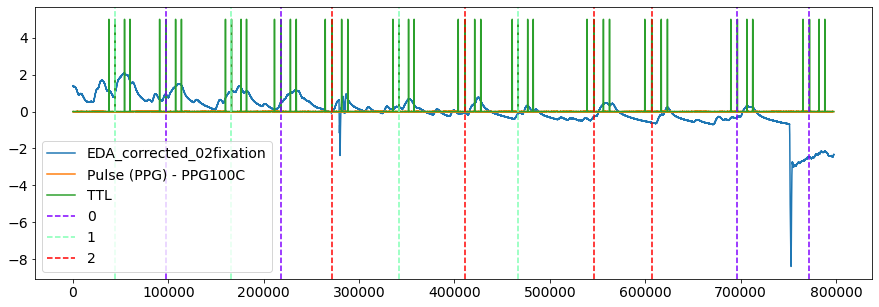

In [70]:
ttl2 = final_df['ttl_2'].values.tolist()
plateau_start = np.ceil(ttl2).astype(int)
event_plateau = {'onset':np.array(plateau_start),
'duration':np.repeat(spacetop_samplingrate*5, 12),
'label':np.array(np.arange(12)),
'condition':beh_df['param_stimulus_type'].values.tolist()}

plot = nk.events_plot(event_plateau, run_physio)

In [71]:
event_plateau

{'onset': array([ 44102,  97634, 166227, 217982, 271691, 341834, 411157, 466713,
        546083, 606726, 696520, 772133]),
 'duration': array([10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
        10000., 10000., 10000., 10000.]),
 'label': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 'condition': ['low_stim',
  'med_stim',
  'low_stim',
  'med_stim',
  'high_stim',
  'low_stim',
  'high_stim',
  'low_stim',
  'high_stim',
  'high_stim',
  'med_stim',
  'med_stim']}

### Manage events: based on trigger column (for physio baseline correction)

## Process biopac data

## 1. EDA 
### 1.1 Process EDA signal 
note: 
- all these steps are included in nk.eda_process and also in nk.bio_process
- with subdiving into low-level functions, we have more control over parameters like: 
    - filters
    - minimum amplitude for SCRs (related to specific stimulus, not non-specific SCRs which appear in every eda signal but are not particularly related to a stimulus)

processing steps include: 
- sanitize signal 
    - returns a default indexed signal (really necessary?)
- filter signal (comparable to nk.eda_clean)
    - returns array with filtered signal 
    - smoothing or low-pass filtering (e.g., Butterworth filter) recommended to remove high-frequency noise and small artifacts
- decompose signal into phasic & tonic component 
    - suggested by neurokit documentation -> helps to provide a more accurate estimation of the true SCR amplitude
    - signal is furthermore standardized which is also suggested by neurokit documentation -> useful in presence of high inter-individual variations, which usually is the case for pain perception
    - EDA_Tonic channel represents the skin conductance level (another measure of tonic skin conductance activity)
- find peaks 
    - returns dict with amplitude of SCR, samples at which SCR onset and SCR peaks occur (accessible with "SCR_Amplitude", "SCR_Onsets", "SCR_Peaks")
- store signal 

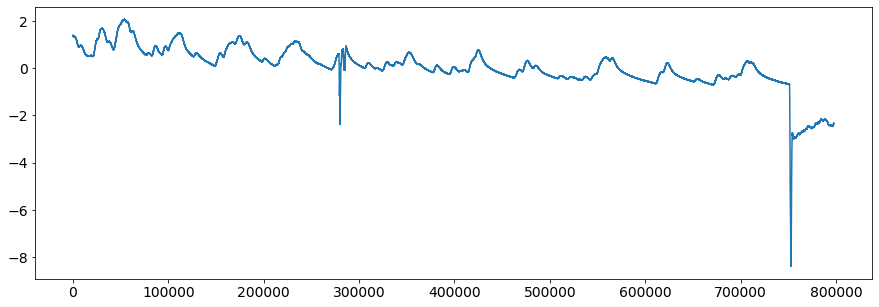

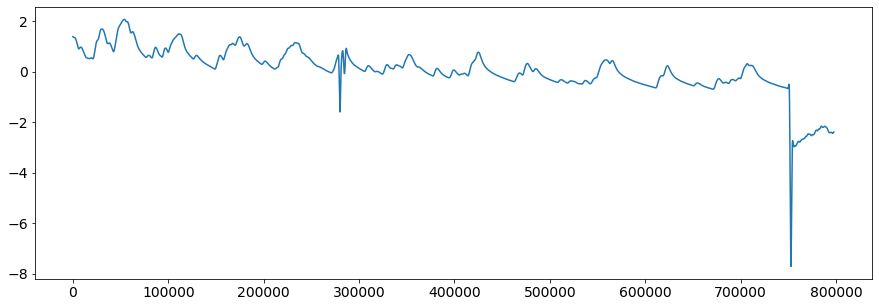

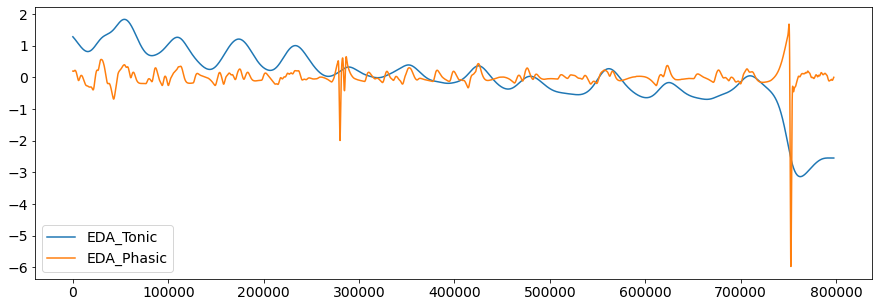

In [74]:
# eda_signal = nk.signal_sanitize(run_physio["Skin Conductance (EDA) - EDA100C-MRI"])

eda_signal = nk.signal_sanitize(run_physio["EDA_corrected_02fixation"])
eda_filters = nk.signal_filter(eda_signal, 
                               sampling_rate=spacetop_samplingrate, 
                               highcut=1, method="butterworth", order=2)
# eda_raw_plot = plt.plot(run_df["Skin Conductance (EDA) - EDA100C-MRI"])
eda_raw_plot = plt.plot(run_df["EDA_corrected_02fixation"])
plt.show(eda_raw_plot)
eda_filters_plot = plt.plot(eda_filters)
plt.show(eda_filters_plot)

eda_decomposed = nk.eda_phasic(nk.standardize(eda_filters), 
                               sampling_rate=spacetop_samplingrate) 
eda_decomposed_plot = eda_decomposed.plot()

eda_peaks, info = nk.eda_peaks(eda_decomposed["EDA_Phasic"].values,
                               sampling_rate=spacetop_samplingrate, 
                               method = "neurokit", amplitude_min = 0.02)  
info["sampling_rate"] = spacetop_samplingrate

signals = pd.DataFrame({"EDA_Raw": eda_signal, "EDA_Clean": eda_filters})
eda_processed = pd.concat([signals, eda_decomposed, eda_peaks], axis=1) 
eda_level_signal = eda_processed["EDA_Tonic"] # for skin conductance level

skip (event stim vs event plateau for scl), see under 2.1. define epochs for EDA signal)

In [ ]:
eda_epochs_tonic_decomposed = nk.epochs_create(eda_level_signal, 
                              event_stim, 
                              sampling_rate=spacetop_samplingrate, 
                              epochs_start=0, 
                              epochs_end=8,
                              baseline_correction=True) # 5 seconds , separate 

#eda_epochs_tonic_decomposed[2].columns
#eda_epochs_tonic_decomposed[0]["Signal"].mean()
#eda_epochs_tonic_decomposed[ind]['Label'].unique()[0]

# loop over dictionary
# calculate mean signal 
# make sure to include the label and condition
#eda_tonic_decomposed_df 
# etd_df

etd_df = pd.DataFrame(index = list(range(len(eda_epochs_tonic_decomposed))),
                      columns=['trial_order', 'iv_stim', 'mean_signal'])
for ind in range(len(eda_epochs_tonic_decomposed)):
    etd_df.iloc[ind, etd_df.columns.get_loc('mean_signal')] = eda_epochs_tonic_decomposed[ind]["Signal"].mean()
    etd_df.iloc[ind, etd_df.columns.get_loc('trial_order')] = eda_epochs_tonic_decomposed[ind]['Label'].unique()[0]
    etd_df.iloc[ind, etd_df.columns.get_loc('iv_stim')] = eda_epochs_tonic_decomposed[ind]["Condition"].unique()[0]

etd_df
# für mehr Konsistenz hier besser eda_processed Tonic channel?? 


KeyError: 0

### 1.2 Define epochs for EDA signal

- eda_epochs: snipping out segments based on start of heat pain stimulus (plateau?) with eda_processed 
- eda_epochs_BL: eda_epochs but with baseline correction (necessary?)  
- eda_epochs_level: snipping out segments based on plateau of heat pain stimulus with tonic channel of eda_processed for skin    conductance level 
- eda_epochs_physioBL: snipping out segments based on trigger column (beginning of experiment) for extraction of physio baseline correction

In [76]:
eda_epochs = nk.epochs_create(eda_processed, 
                              event_stim, 
                              sampling_rate=spacetop_samplingrate, 
                              epochs_start=0, 
                              epochs_end=9)
eda_epochs                             

{'0':          EDA_Raw  EDA_Clean  EDA_Tonic  EDA_Phasic  SCR_Onsets  SCR_Peaks  \
 0.0000  1.134325   1.133110   1.386487   -0.191113           0          0   
 0.0005  1.135851   1.133128   1.386504   -0.191111           0          0   
 0.0010  1.135851   1.133146   1.386521   -0.191108           0          0   
 0.0015  1.131273   1.133164   1.386539   -0.191106           0          0   
 0.0020  1.135851   1.133181   1.386556   -0.191104           0          0   
 ...          ...        ...        ...         ...         ...        ...   
 8.9980  1.988817   1.993089   1.818114    0.323356           0          0   
 8.9985  1.985765   1.993045   1.818100    0.323321           0          0   
 8.9990  1.988817   1.993000   1.818086    0.323286           0          0   
 8.9995  1.993395   1.992956   1.818072    0.323251           0          0   
 9.0000  1.990343   1.992911   1.818058    0.323216           0          0   
 
         SCR_Height  SCR_Amplitude  SCR_RiseTime  SCR_Rec

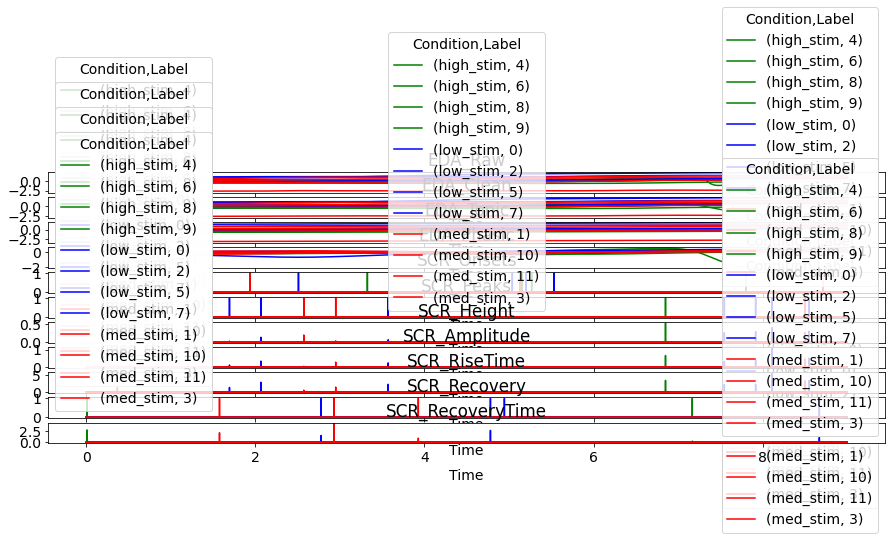

In [77]:
eda_epochs_plot = nk.epochs_plot(eda_epochs)

In [78]:
eda_epochs_BL = nk.epochs_create(eda_processed, 
                                 event_stim, 
                                 sampling_rate=spacetop_samplingrate, 
                                 epochs_start=0, 
                                 epochs_end=9,
                                 baseline_correction=True)
eda_epochs_BL

{'0':          EDA_Raw  EDA_Clean  EDA_Tonic  EDA_Phasic  SCR_Onsets  SCR_Peaks  \
 0.0000  0.000000   0.000000   0.000000    0.000000         0.0        0.0   
 0.0005  0.001526   0.000018   0.000017    0.000002         0.0        0.0   
 0.0010  0.001526   0.000036   0.000035    0.000005         0.0        0.0   
 0.0015 -0.003052   0.000054   0.000052    0.000007         0.0        0.0   
 0.0020  0.001526   0.000071   0.000069    0.000009         0.0        0.0   
 ...          ...        ...        ...         ...         ...        ...   
 8.9980  0.854492   0.859979   0.431628    0.514469         0.0        0.0   
 8.9985  0.851440   0.859935   0.431614    0.514434         0.0        0.0   
 8.9990  0.854492   0.859890   0.431600    0.514399         0.0        0.0   
 8.9995  0.859070   0.859846   0.431585    0.514364         0.0        0.0   
 9.0000  0.856018   0.859801   0.431571    0.514329         0.0        0.0   
 
         SCR_Height  SCR_Amplitude  SCR_RiseTime  SCR_Rec

In [79]:
eda_epochs_level = nk.epochs_create(eda_level_signal, 
                                    event_plateau, 
                                    sampling_rate=spacetop_samplingrate, 
                                    epochs_start=-1, 
                                    epochs_end=8,
                                    baseline_correction=True)
eda_epochs_level

eda_epochs_tonic_decomposed = nk.epochs_create(eda_level_signal, 
                              event_plateau, 
                              sampling_rate=spacetop_samplingrate, 
                              epochs_start=-1, 
                              epochs_end=8,
                              baseline_correction=True)
eda_epochs_tonic_decomposed               

<AxesSubplot:>

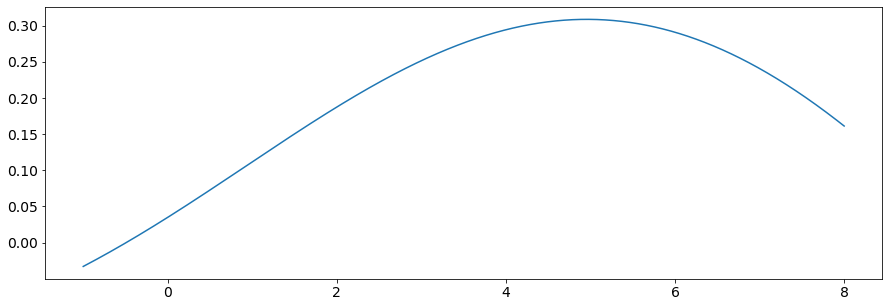

In [92]:
eda_epochs_level[0]["Signal"].plot()


### 1.3 Analyze EDA signal 
- eda phasic 
    - event-related analysis
    - of interest especially when analyzing EDA responses to specific stimuli 
    - returns: 
        - EDA_SCR: Skin Conductance Response yes (1) or no (0) -> if yes, corresponding components are listed 
        - EDA_Peak_Amplitude: maximum amplitude of phasic component of signal 
        - SCR_Peak_Amplitude: peak amplitude of the first SCR in each epoch (parameter of interest if related to specific stimulus)
        - SCR_Peak_Amplitude_Time: timpepoint of each first SCR peak amplitude (peak should occur within 2-7 s after stimulus onset)
        - SCR_RiseTime: risetime of each first SCR (time it takes for SCR to reach peak amplitude from onset) 
        - SCR_RecoveryTime: half-recovery time of each first SCR (time it takes for SCR to decrease to half amplitude)
- eda tonic 
    - interval-related analysis
    - of interest for longer time periods, also resting-state (input could therefore also be a whole condition instead of snipped-out epochs)
    - returns: 
        - SCR_Peaks_N: number of occurrences of Skin Conductance Response 
        - SCR_Peaks_Amplitude_Mean: mean amplitude of SCR peak occurrences 
- eda level
    - analysis of skin conductance level 

In [81]:
eda_phasic = nk.eda_eventrelated(eda_epochs)
eda_phasic

,Label,Condition,Event_Onset,EDA_Peak_Amplitude,EDA_SCR,SCR_Peak_Amplitude,SCR_Peak_Amplitude_Time,SCR_RiseTime,SCR_RecoveryTime
0,0,low_stim,37732,0.396235,1,1.084711,8.110951,5.6005,NaN
1,1,med_stim,90817,0.237071,1,0.292987,2.950664,1.5440,7854.0
2,2,low_stim,159839,0.260698,1,0.349956,2.065615,2.9525,9560.0
3,3,med_stim,211206,0.139827,0,NaN,NaN,NaN,NaN
4,4,high_stim,264438,0.584637,1,0.668730,6.851381,3.5260,14335.0
5,5,low_stim,335437,0.300076,1,0.124626,1.694094,1.4240,5556.0
6,6,high_stim,403801,0.157723,0,NaN,NaN,NaN,NaN
7,7,low_stim,460417,0.293118,1,0.245370,3.571698,2.3590,9890.0
8,8,high_stim,538830,0.227121,0,NaN,NaN,NaN,NaN
9,9,high_stim,599433,0.084317,0,NaN,NaN,NaN,NaN


In [82]:
eda_phasic_BL = nk.eda_eventrelated(eda_epochs_BL)
eda_phasic_BL

,Label,Condition,Event_Onset,EDA_Peak_Amplitude,EDA_SCR,SCR_Peak_Amplitude,SCR_Peak_Amplitude_Time,SCR_RiseTime,SCR_RecoveryTime
0,0,low_stim,0.0,0.587348,1,1.084711,8.110951,5.6005,NaN
1,1,med_stim,0.0,0.329118,1,0.292987,2.950664,1.5440,7854.0
2,2,low_stim,0.0,0.304556,1,0.349956,2.065615,2.9525,9560.0
3,3,med_stim,0.0,0.333817,0,NaN,NaN,NaN,NaN
4,4,high_stim,0.0,0.612201,1,0.668730,6.851381,3.5260,14335.0
5,5,low_stim,0.0,0.387135,1,0.124626,1.694094,1.4240,5556.0
6,6,high_stim,0.0,0.194150,0,NaN,NaN,NaN,NaN
7,7,low_stim,0.0,0.414627,1,0.245370,3.571698,2.3590,9890.0
8,8,high_stim,0.0,0.225088,0,NaN,NaN,NaN,NaN
9,9,high_stim,0.0,0.069348,0,NaN,NaN,NaN,NaN


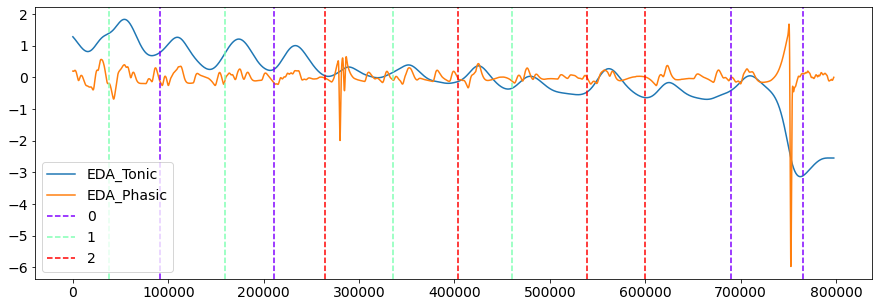

In [83]:
plot_eda_phasic = nk.events_plot(event_stim, 
                                 eda_processed[["EDA_Tonic", "EDA_Phasic"]])

In [84]:
eda_tonic = nk.eda_intervalrelated(eda_epochs)
eda_tonic

,Label,SCR_Peaks_N,SCR_Peaks_Amplitude_Mean
0,0,1,1.084711
1,1,1,0.292987
2,2,2,0.341002
3,3,0,NaN
4,4,1,0.668730
5,5,2,0.319767
6,6,0,NaN
7,7,2,0.327765
8,8,0,NaN
9,9,0,NaN


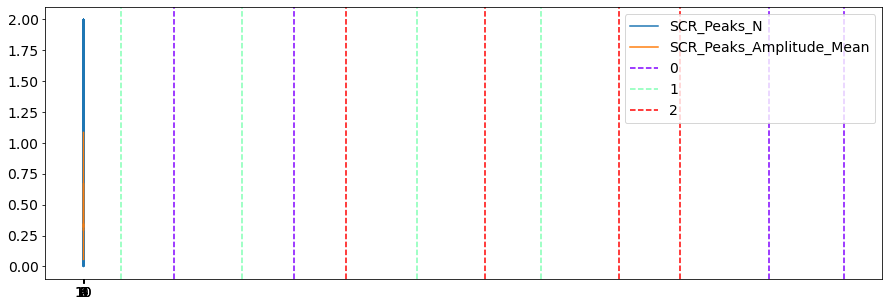

In [85]:
plot_tonic = nk.events_plot(event_stim, eda_tonic)

In [86]:
eda_tonic_BL = nk.eda_eventrelated(eda_epochs_BL)
eda_tonic_BL

,Label,Condition,Event_Onset,EDA_Peak_Amplitude,EDA_SCR,SCR_Peak_Amplitude,SCR_Peak_Amplitude_Time,SCR_RiseTime,SCR_RecoveryTime
0,0,low_stim,0.0,0.587348,1,1.084711,8.110951,5.6005,NaN
1,1,med_stim,0.0,0.329118,1,0.292987,2.950664,1.5440,7854.0
2,2,low_stim,0.0,0.304556,1,0.349956,2.065615,2.9525,9560.0
3,3,med_stim,0.0,0.333817,0,NaN,NaN,NaN,NaN
4,4,high_stim,0.0,0.612201,1,0.668730,6.851381,3.5260,14335.0
5,5,low_stim,0.0,0.387135,1,0.124626,1.694094,1.4240,5556.0
6,6,high_stim,0.0,0.194150,0,NaN,NaN,NaN,NaN
7,7,low_stim,0.0,0.414627,1,0.245370,3.571698,2.3590,9890.0
8,8,high_stim,0.0,0.225088,0,NaN,NaN,NaN,NaN
9,9,high_stim,0.0,0.069348,0,NaN,NaN,NaN,NaN


In [87]:
# loop over dictionary
# calculate mean signal 
# make sure to include the label and condition
# eda_tonic_decomposed_df 
# etd_df

eda_level = pd.DataFrame(index = list(range(len(eda_epochs_level))),
                         columns=['trial_order', 'iv_stim', 'mean_signal'])
for ind in range(len(eda_epochs_level)):
    eda_level.iloc[ind, eda_level.columns.get_loc('mean_signal')] = eda_epochs_level[ind]["Signal"].mean()
    eda_level.iloc[ind, eda_level.columns.get_loc('trial_order')] = eda_epochs_level[ind]['Label'].unique()[0]
    eda_level.iloc[ind, eda_level.columns.get_loc('iv_stim')] = eda_epochs_level[ind]["Condition"].unique()[0]

eda_level

,trial_order,iv_stim,mean_signal
0,0,low_stim,0.199571
1,1,med_stim,0.214335
2,2,low_stim,0.114292
3,3,med_stim,0.328961
4,4,high_stim,0.128377
5,5,low_stim,0.093113
6,6,high_stim,0.225111
7,7,low_stim,0.172781
8,8,high_stim,0.320414
9,9,high_stim,0.205503


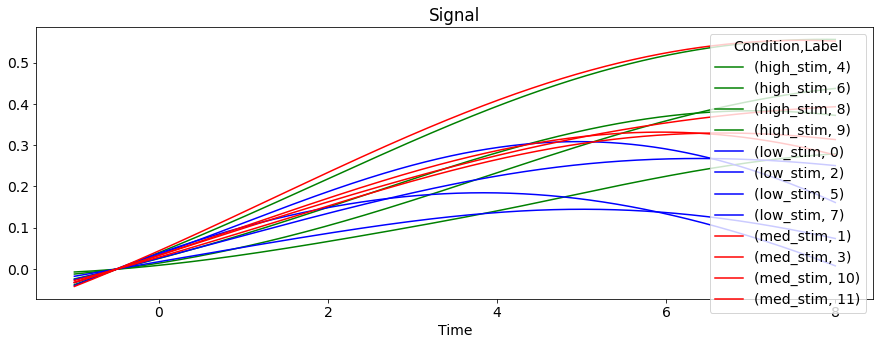

In [88]:
plot_level = nk.epochs_plot(eda_epochs_level)

In [89]:
eda_physioBL = pd.DataFrame(index = list(range(len(eda_epochs_physioBL))),
                              columns=['trial_order', 'iv_stim', 'mean_signal'])
for ind in range(len(eda_epochs_physioBL)):
    eda_physioBL.iloc[ind, eda_physioBL.columns.get_loc('mean_signal')] = eda_epochs_physioBL[ind]["Signal"].mean()
    eda_physioBL.iloc[ind, eda_physioBL.columns.get_loc('trial_order')] = eda_epochs_physioBL[ind]['Label'].unique()[0]
    eda_physioBL.iloc[ind, eda_physioBL.columns.get_loc('iv_stim')] = eda_epochs_physioBL[ind]["Condition"].unique()[0]

eda_physioBL

KeyError: 0

### 1.5 EDA plots

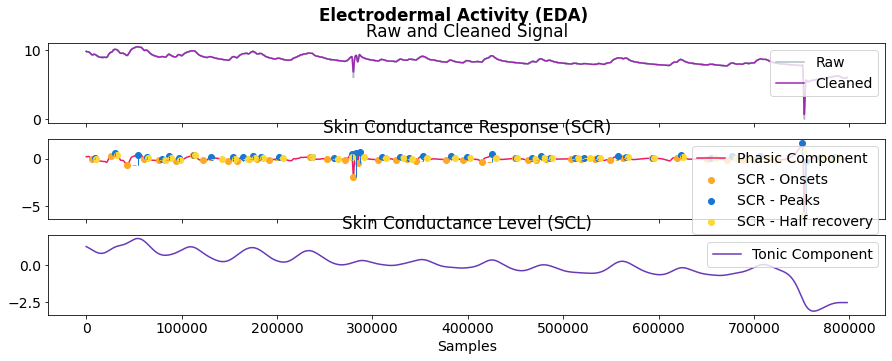

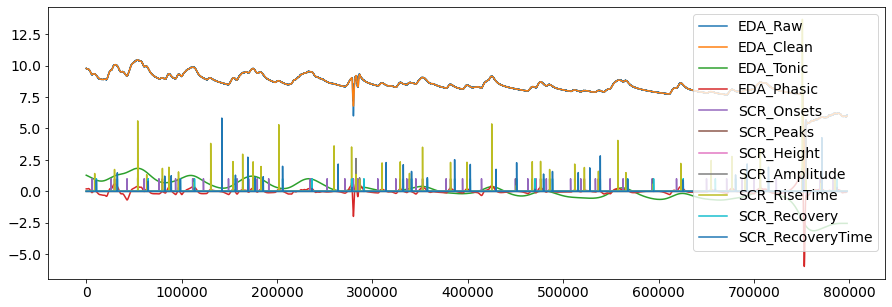

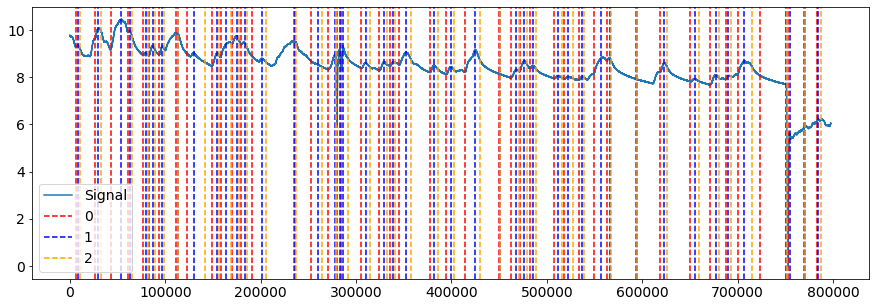

In [ ]:
eda_plot = nk.eda_plot(eda_processed)
eda_processed_plot = eda_processed.plot() 

eda_features = [info["SCR_Onsets"], info["SCR_Peaks"], info["SCR_Recovery"]]
eda_features_plot = nk.events_plot(eda_features, eda_signal, color= ['red', 'blue', 'orange']) 

#plot_clean_signal = run_df_clean[["EDA_Tonic", "EDA_Phasic", "PPG_Clean", "PPG_Rate"]].plot(subplots=True)

## 2. PPG
### 2.1 Process PPG signal 
note: 
- all these steps are included in nk.ppg_process and also in nk.bio_process
    - follows exactly the Elgendi method in nk.ppg_process, but with this approach we could always adjust filter parameters 
- with subdiving into low-level functions, we have more control over parameters like: 
    - filters

processing steps include: 
- sanitize signal 
    - returns a default indexed signal (really necessary?)
- filter signal (comparable to nk.ppg_clean)
    - returns array with filtered signal 
- find peaks 
    - returns dict with the samples at which systolic peaks occur (accessible with "PPG_Peaks")
- mark peaks 
- compute rate 
    - signal rate from series of peaks (60/period)
- store signal 

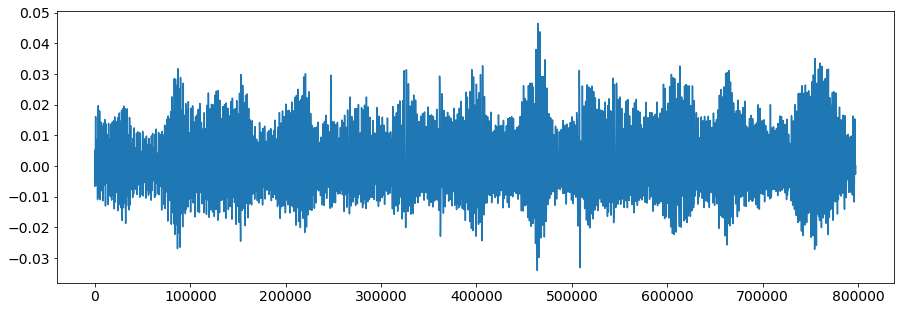

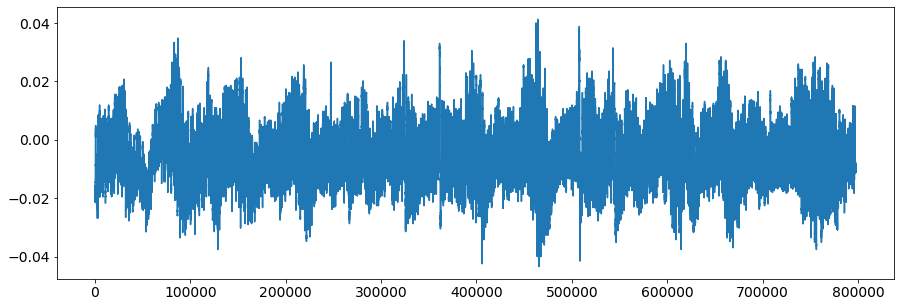

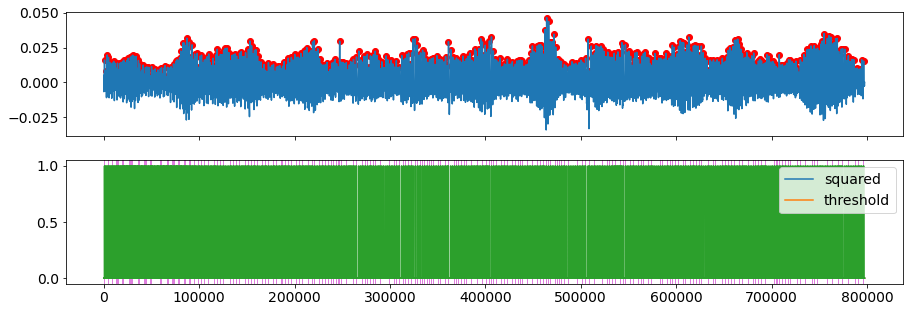

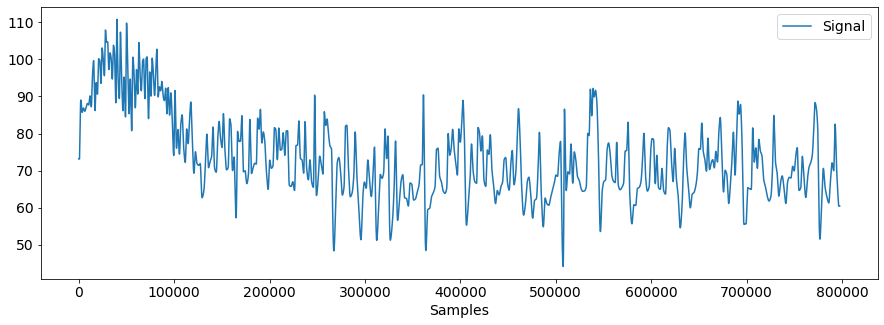

In [ ]:
ppg_signal = nk.signal_sanitize(run_physio["Pulse (PPG) - PPG100C"])

ppg_filters = nk.signal_filter(ppg_signal, 
                               sampling_rate=spacetop_samplingrate, 
                               highcut=8, lowcut = 0.5, method="butter_ba", order=3)
plot_ppg_filters = plt.plot(ppg_filters)
plt.show(plot_ppg_filters)
plot_ppg_raw = plt.plot(run_df["Pulse (PPG) - PPG100C"])
plt.show(plot_ppg_raw)

ppg_peaks = nk.ppg_findpeaks(ppg_filters,
                             sampling_rate = spacetop_samplingrate, 
                             show = True)  
ppg_peaks["sampling_rate"] = spacetop_samplingrate

from neurokit2.signal.signal_formatpeaks import _signal_from_indices
ppg_markedpeaks = _signal_from_indices(ppg_peaks["PPG_Peaks"], desired_length = len(ppg_filters))
ppg_markedpeaks.plot()

from neurokit2.signal import signal_rate
ppg_rate = nk.signal_rate(ppg_peaks["PPG_Peaks"], 
                          sampling_rate= spacetop_samplingrate, 
                          desired_length = len(ppg_filters))
ppg_rate_plot = nk.signal_plot(ppg_rate)

ppg_processed = pd.DataFrame(
        {
            "PPG_Raw": ppg_signal,
            "PPG_Clean": ppg_filters,
            "PPG_Rate": ppg_rate,
            "PPG_Peaks": ppg_markedpeaks,
        }
    )

### 2.2 Define epochs for PPG

- ppg_epochs: snipping out segments based on start of heat pain stimulus (plateau?) with ppg_processed 
- ppg_epochs_BL: ppg_epochs but with baseline correction (necessary?)  
- ppg_epochs_physioBL: snipping out segments based on trigger column (beginning of experiment) for extraction of physio baseline correction

In [ ]:
ppg_epochs = nk.epochs_create(ppg_processed, 
                              event_stim, 
                              sampling_rate=spacetop_samplingrate, 
                              epochs_start=-1, 
                              epochs_end=6)
ppg_epochs

{'0':           PPG_Raw  PPG_Clean    PPG_Rate  PPG_Peaks  Index Label Condition
 -1.0000 -0.020142  -0.008009   98.734064        0.0  35732     0  low_stim
 -0.9995 -0.020752  -0.008023   98.745741        0.0  35733     0  low_stim
 -0.9990 -0.020447  -0.008037   98.757423        0.0  35734     0  low_stim
 -0.9985 -0.019531  -0.008052   98.769110        0.0  35735     0  low_stim
 -0.9980 -0.020447  -0.008066   98.780801        0.0  35736     0  low_stim
 ...           ...        ...         ...        ...    ...   ...       ...
  5.9980 -0.022888  -0.009432  101.413083        0.0  49727     0  low_stim
  5.9985 -0.023193  -0.009444  101.447878        0.0  49728     0  low_stim
  5.9990 -0.023499  -0.009456  101.482653        0.0  49729     0  low_stim
  5.9995 -0.023804  -0.009466  101.517409        0.0  49730     0  low_stim
  6.0000 -0.023499  -0.009475  101.552144        0.0  49731     0  low_stim
 
 [14000 rows x 7 columns],
 '1':           PPG_Raw  PPG_Clean   PPG_Rate  PPG_Pea

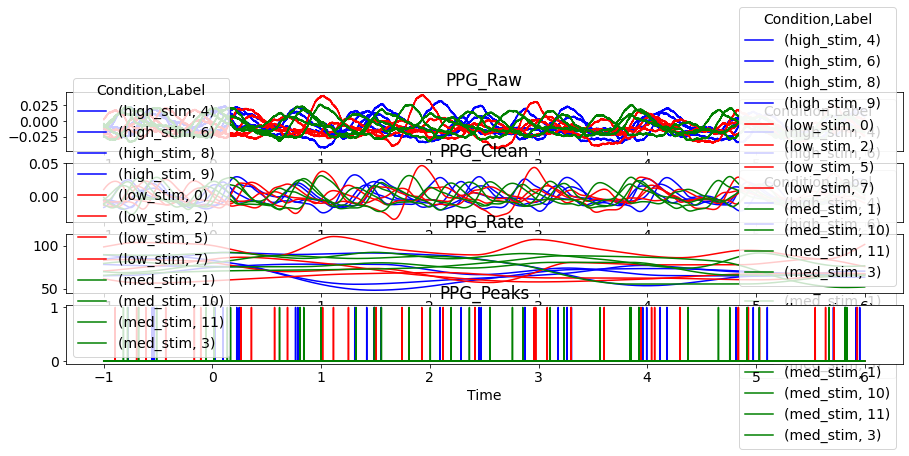

In [ ]:
ppg_epochs_plot = nk.epochs_plot(ppg_epochs)

In [ ]:
ppg_epochs_BL = nk.epochs_create(ppg_processed, 
                                 event_stim, 
                                 sampling_rate=spacetop_samplingrate, 
                                 epochs_start=-1, 
                                 epochs_end=6,
                                 baseline_correction=True) 
ppg_epochs_BL

{'0':           PPG_Raw  PPG_Clean  PPG_Rate  PPG_Peaks    Index Label Condition
 -1.0000 -0.009702  -0.009092 -3.767282     -0.001   -999.5     0  low_stim
 -0.9995 -0.010313  -0.009107 -3.755605     -0.001   -998.5     0  low_stim
 -0.9990 -0.010007  -0.009121 -3.743923     -0.001   -997.5     0  low_stim
 -0.9985 -0.009092  -0.009135 -3.732236     -0.001   -996.5     0  low_stim
 -0.9980 -0.010007  -0.009150 -3.720546     -0.001   -995.5     0  low_stim
 ...           ...        ...       ...        ...      ...   ...       ...
  5.9980 -0.012449  -0.010515 -1.088264     -0.001  12995.5     0  low_stim
  5.9985 -0.012754  -0.010528 -1.053468     -0.001  12996.5     0  low_stim
  5.9990 -0.013059  -0.010539 -1.018693     -0.001  12997.5     0  low_stim
  5.9995 -0.013364  -0.010549 -0.983937     -0.001  12998.5     0  low_stim
  6.0000 -0.013059  -0.010559 -0.949203     -0.001  12999.5     0  low_stim
 
 [14000 rows x 7 columns],
 '1':           PPG_Raw  PPG_Clean   PPG_Rate  PPG_Pea

In [ ]:
ppg_epochs_physioBL = nk.epochs_create(ppg_processed, 
                                       event_physioBL, 
                                       sampling_rate=spacetop_samplingrate, 
                                       epochs_start=0, 
                                       epochs_end=2.76)
type(ppg_epochs_physioBL)

dict

### 2.3 Analyze PPG signal 
- ppg phasic 
    - event-related anaylsis
    - of interest especially when analyzing EDA responses to specific stimuli 
    - returns: 
        - PPG_Rate_Baseline: baseline heart rate (at stimulus onset) 
        - PPG_Rate_Max: maximum heart rate after stimulus onset 
        - PPG_Rate_Min: minimum heart rate after stimulus onset 
        - PPG_Rate_Mean: mean heart rate after stimulus onset 
        - PPG_Rate_SD: standard deviation of the heart rate after stimulus onset
        - PPG_Rate_Max_Time: time at which maximum heart rate occurs 
        - PPG_Rate_Min_Time: time at which minimum heart rate occurs 
        - PPG_Rate_Trend_Linear: parameter corresponding to linear trend 
        - PPG_Rate_Trend_Quadratic: parameter corresponding to curvature 
        - PPG_Rate_Trend_R2: quality of quadratic model, if too low parameters might not be reliable or meaningful 
- ppg tonic -> not working yet, but really necessary? 
    - interval-related anaylsis
    - of interest for longer time periods, also resting-state (input could therefore also be a whole condition instead of snipped-out epochs)
    - returns: 
        - HRV (but makes sense only if time interval is longer than 1 min)

In [ ]:
ppg_phasic = nk.ppg_eventrelated(ppg_epochs)
ppg_phasic

,Label,Condition,Event_Onset,PPG_Rate_Baseline,PPG_Rate_Max,PPG_Rate_Min,PPG_Rate_Mean,PPG_Rate_SD,PPG_Rate_Max_Time,PPG_Rate_Min_Time,PPG_Rate_Trend_Linear,PPG_Rate_Trend_Quadratic,PPG_Rate_Trend_R2
0,0,low_stim,37732,100.309081,10.494243,-15.802039,-5.560119,6.833931,1.113151,5.640474,1.681204,-4.035109,0.211286
1,1,med_stim,90817,91.841085,0.537668,-17.767011,-6.331571,5.436703,1.489678,4.375884,-1.245007,-1.282002,0.370115
2,2,low_stim,159839,80.622336,4.183318,-23.343100,-6.641065,7.213117,5.545468,2.552754,-4.683530,-6.325814,0.456435
3,3,med_stim,211206,75.523916,5.229785,-9.806501,-0.980801,5.450889,3.850346,5.671977,4.999952,-2.005684,0.727630
4,4,high_stim,264438,76.203823,-0.000409,-27.855717,-10.999277,8.522096,0.000571,1.487678,-0.651222,-13.612271,0.124385
5,5,low_stim,335437,59.302493,9.583844,0.003573,4.792378,2.724102,2.122223,0.000571,0.821495,4.911036,0.134308
6,6,high_stim,403801,82.942864,-0.008657,-27.668797,-15.864803,6.970468,0.000571,1.309165,-2.638236,-15.271042,0.119696
7,7,low_stim,460417,84.508124,2.197078,-26.509091,-16.286029,8.812654,0.262090,2.960283,-17.812801,7.613724,0.919100
8,8,high_stim,538830,91.688536,0.477363,-38.117107,-16.436775,13.998549,0.097078,3.994857,-12.978012,10.165641,0.748907
9,9,high_stim,599433,74.928882,3.708077,-9.958660,-3.662475,5.040238,0.785628,5.104436,-4.712800,5.704908,0.684100


In [ ]:
ppg_phasic_BL = nk.ppg_eventrelated(ppg_epochs_BL)
ppg_phasic_BL

In [ ]:
ppg_tonic = nk.ppg_intervalrelated(ppg_epochs, sampling_rate = spacetop_samplingrate) # error message 
ppg_tonic

### 2.5 PPG plots

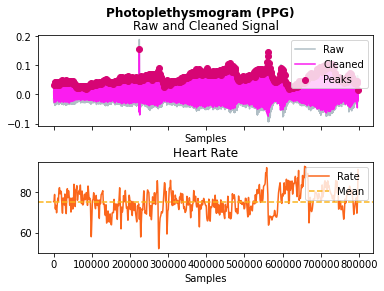

In [ ]:
ppg_plot = nk.ppg_plot(ppg_processed)

#plot_clean_signal = run_df_clean[["EDA_Tonic", "EDA_Phasic", "PPG_Clean", "PPG_Rate"]].plot(subplots=True)

## 3. Export parameter to csv

note: 
- export physio parameters to csv file 
- reshape from 0 - 11 
- Heejung: what do want to include in csv file? 
- more automated creation of csv (naming with subj id etc.)

In [ ]:
#eda_phasic.to_csv("eda_phasic.csv")
#eda_tonic.to_csv("eda_tonic.csv")
#eda_level.to_csv("eda_level.csv")
ppg_phasic.to_csv("ppg_phasic.csv")

In [ ]:
# reshape pandas from 0 - 11 (not working)
#eda_phasic.reset_index(inplace=True)
#eda_tonic.reset_index(inplace=True)
#eda_level.reset_index(inplace=True)
ppg_phasic.reset_index(inplace=True)

In [ ]:
physio_features = pd.merge(eda_level, 
                            ppg_phasic[['Event_Onset', 'PPG_Rate_Baseline',
                                        'PPG_Rate_Max', 'PPG_Rate_Min', 'PPG_Rate_Mean', 'PPG_Rate_SD',
                                        'PPG_Rate_Max_Time', 'PPG_Rate_Min_Time', 'PPG_Rate_Trend_Linear',
                                        'PPG_Rate_Trend_Quadratic', 'PPG_Rate_Trend_R2']], 
                            left_index=True, 
                            right_index = True)
physio_features = physio_features.rename({'Event_Onset_x': 'Event_Onset_EDA', 
                                          'Event_Onset_y': 'Event_Onset_PPG'}, 
                                          axis=1)

In [ ]:
physio_features.to_csv("physio_features.csv")

In [ ]:
beh_physio = pd.merge(beh_df[['src_subject_id', 'session_id', 'param_task_name', 'param_run_num',
                              'param_counterbalance_ver', 'param_counterbalance_block_num',
                              'param_cue_type', 'param_stimulus_type', 'param_cond_type',
                              'param_trigger_onset', 'param_start_biopac',]], 
                              physio_features,
                              left_index=True, 
                              right_index = True)
beh_physio.to_csv("beh_physio_pain.csv")

In [ ]:
beh_physio = pd.merge(physio_features, beh_df, left_index=True, right_index = True)
beh_physio["sub_id"] = "51"